In [311]:
import georinex as gr
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
from scipy.optimize import curve_fit, leastsq
from scipy import signal
from scipy.interpolate import RectBivariateSpline
import os

# for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from curlyBrace import curlyBrace

# for data
from dataclasses import dataclass, field
from typing import Optional, List

# own functions
from sv_functions import *

# for warnings
import warnings
warnings.filterwarnings("ignore", message="On entry to DLASCL parameter number 4 had an illegal value")


In [312]:
def return_date(chip_short, material):
    if material == 'clean':
        if chip_short == 'wide':
            date = f'190524'
        elif chip_short == 'normal':
            date = f'150524'
        elif chip_short == 'tight':
            date = f'150524'
    elif material == 'brick':
        if chip_short == 'wide':
            date = f'230524_8'
        elif chip_short == 'normal':
            date = f'190524'
        elif chip_short == 'tight':
            date = f'150524'
    elif material == 'glass':
        if chip_short == 'wide':
            date = f'270524'
        elif chip_short == 'normal':
            date = f'190524'
        elif chip_short == 'tight':
            date = f'270524'
    elif material == 'metal':
        if chip_short == 'wide':
            date = f'270524'
        elif chip_short == 'normal':
            date = f'270524'
        elif chip_short == 'tight':
            date = f'270524'

    return date

def get_chip_spacing(chip_setting):
    if chip_setting == 'wide':
        chip_spacing = 'chip_0.8narrow_0.3'
    elif chip_setting == 'normal':
        chip_spacing = 'chip_0.5narrow_0.15'
    elif chip_setting == 'tight':
        chip_spacing = 'chip_0.2narrow_0.1'

    return chip_spacing

In [313]:
## RINEX files from GNSS-SDR

curly_brace_bool = True

material = f'clean'
# material = f'brick'
# material = f'metal'
# material = f'glass'

signal = f'L1+L5'

chip_spacing = 'chip_0.5narrow_0.15'
# chip_spacing = 'chip_0.8narrow_0.3'
# chip_spacing = 'chip_0.2narrow_0.1'

if 'chip_0.8' in chip_spacing:
    chip_short = 'wide'
elif 'chip_0.5' in chip_spacing:
    chip_short = 'normal'
elif 'chip_0.2' in chip_spacing:
    chip_short = 'tight'

date = return_date(chip_short, material)

obs_file = f'{date}.24O'
nav_file = f'{date}.24N'

path = f'../software_receiver/GNSS-SDR/data/{signal}/{material}/{chip_spacing}/'

obs_main = gr.load(path+obs_file)
nav_main = gr.load(path+nav_file)

In [314]:
# constants
freq_L1 = 10.23e06 * 154 # Hz
freq_L2 = 10.23e06 * 120 # Hz
freq_L5 = 10.23e06 * 115 # Hz
c = 299792458 # m/s

alpha = nav_main.ionospheric_corr_GPS[:4]
beta = nav_main.ionospheric_corr_GPS[4:]

pseudorange_L1_selector = 'C1C'
pseudorange_L2_selector = 'C2L'
pseudorange_L5_selector = 'C5Q'
carrier_phase_L1_selector = 'L1C'
carrier_phase_L2_selector = 'L2L'
carrier_phase_L5_selector = 'L5Q'

# true position
true_pos_ecef = np.array(obs_main.position)
true_pos_lla = ecef_to_lla(true_pos_ecef[0],true_pos_ecef[1],true_pos_ecef[2])

# bands to use:
USE_L1 = True
USE_L2 = False
USE_L5 = True

/tmp/ipykernel_14539/3634466893.py:22: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pseudorange_L5)):
/tmp/ipykernel_14539/3634466893.py:22: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pseudorange_L5)):
/tmp/ipykernel_14539/3634466893.py:22: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pseudorange_L5)):


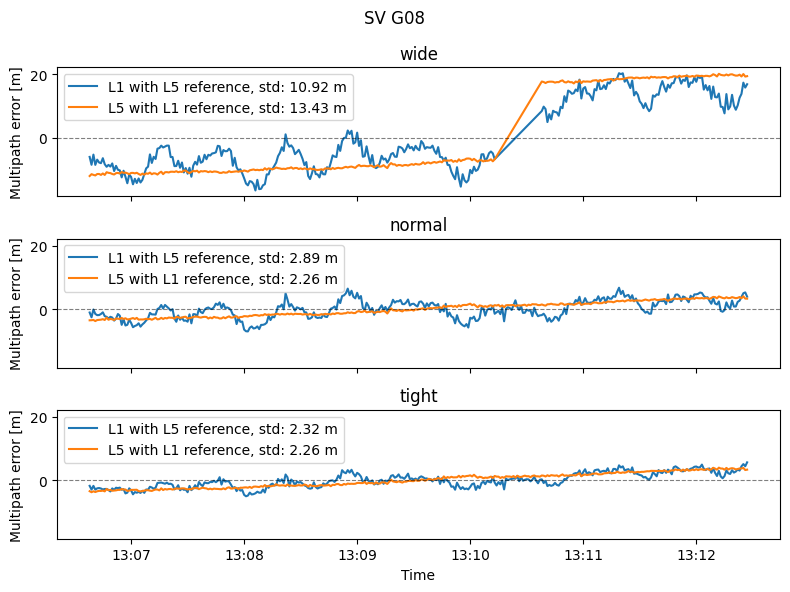

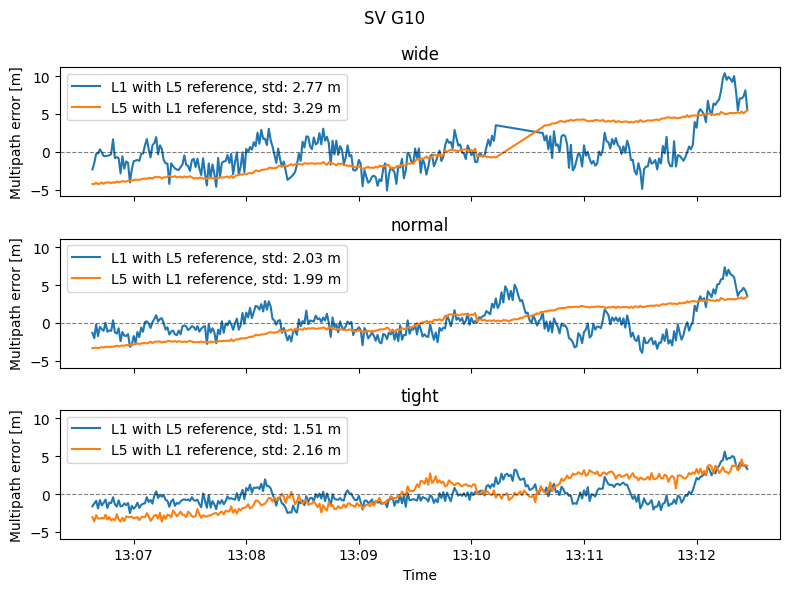

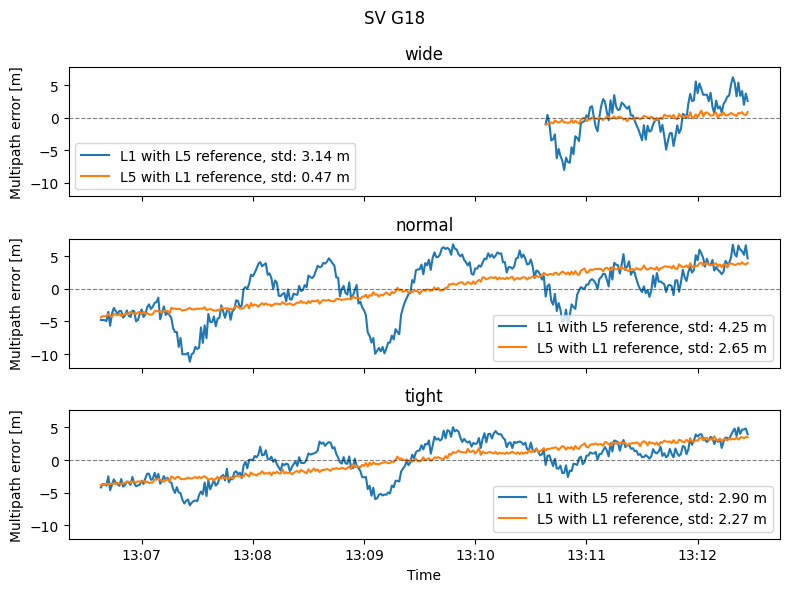

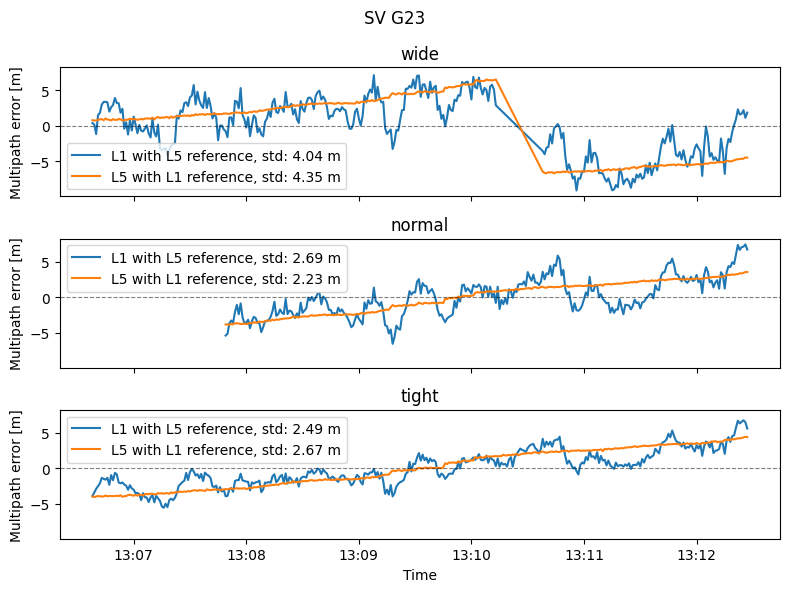

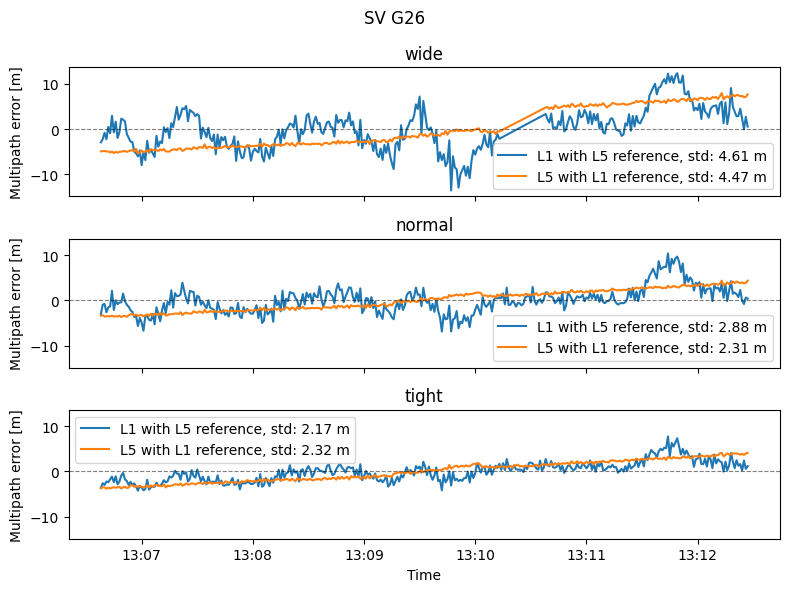

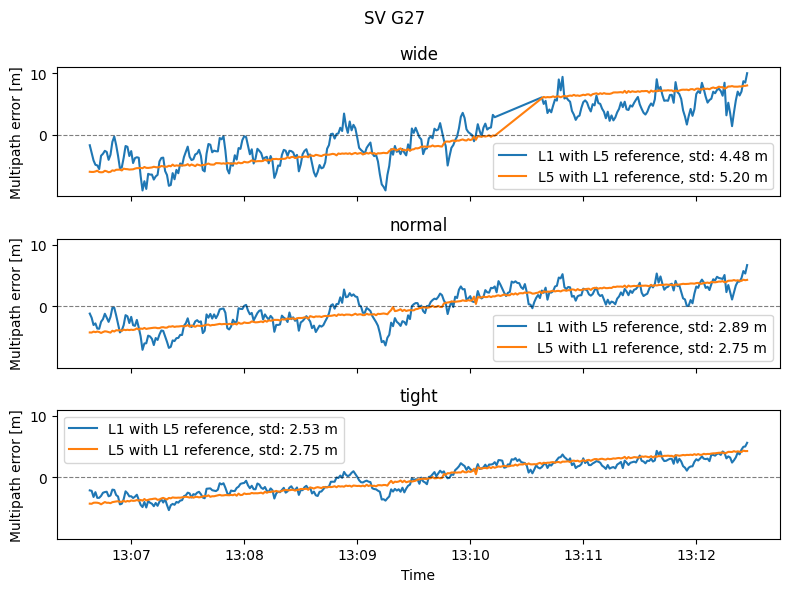

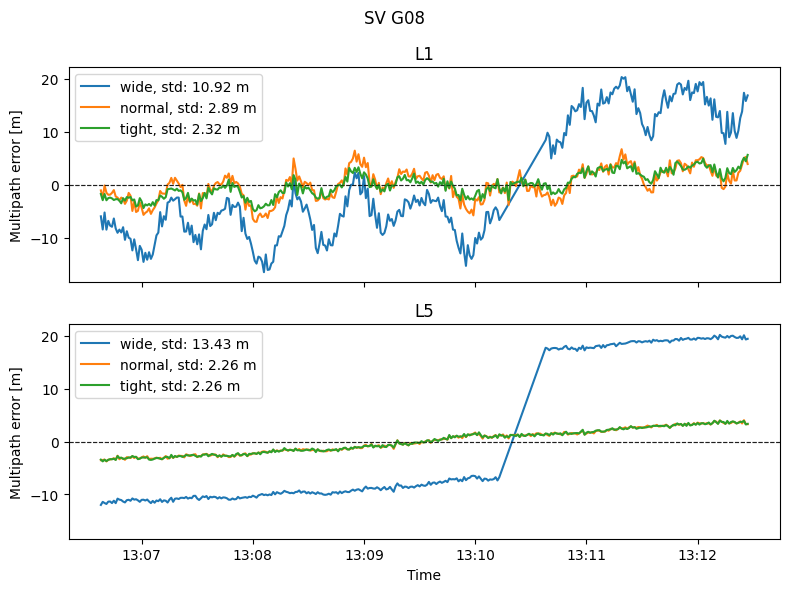

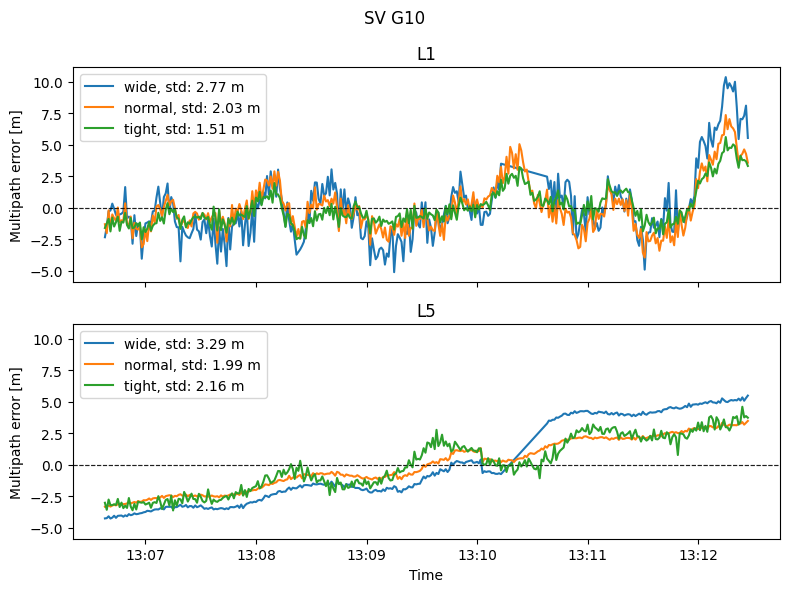

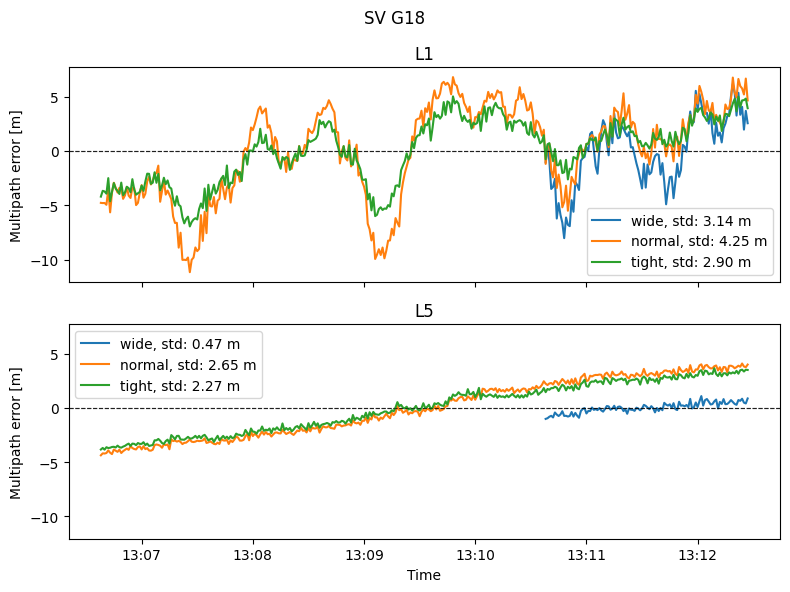

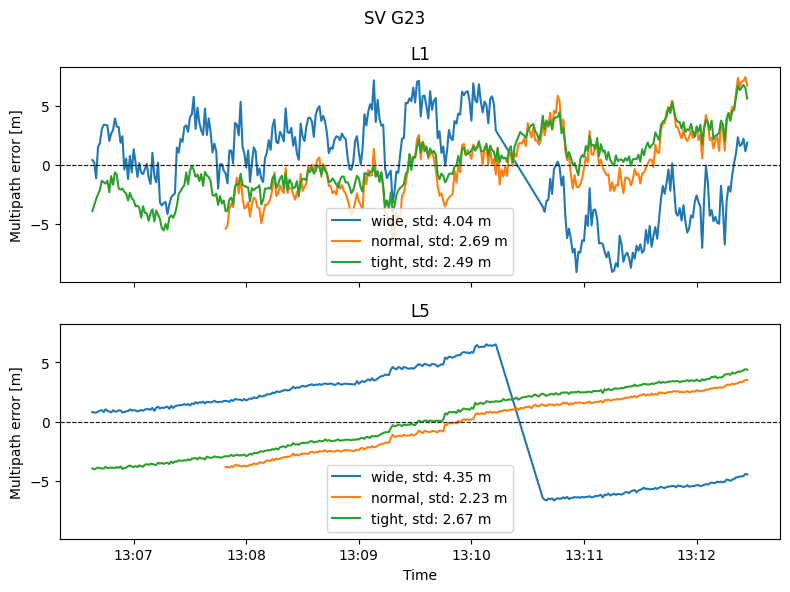

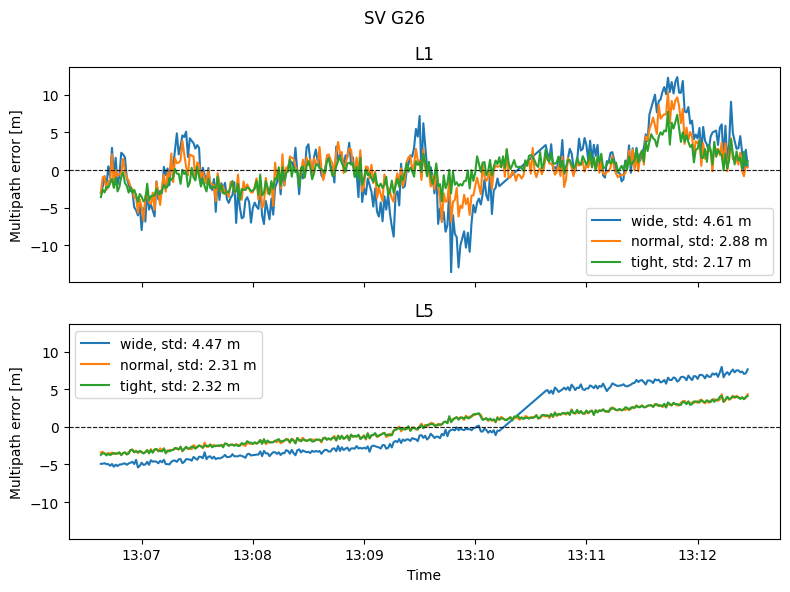

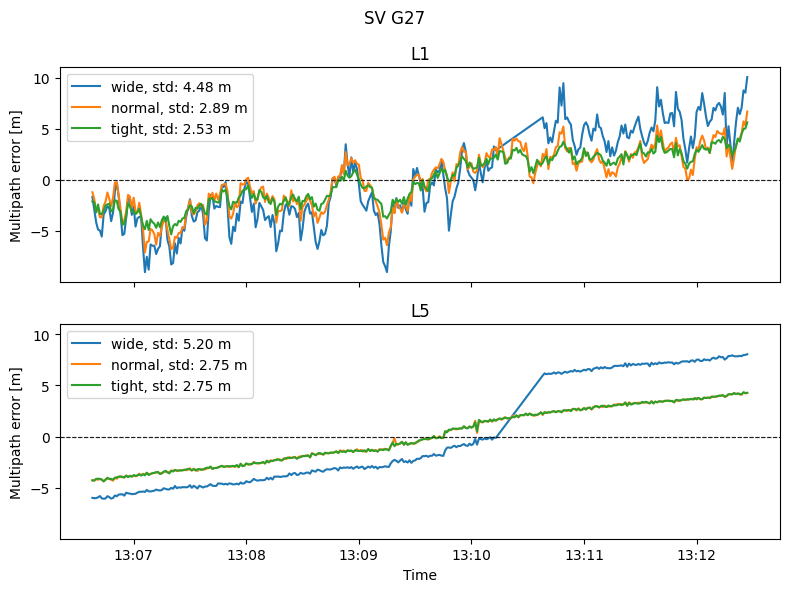

/tmp/ipykernel_14539/3634466893.py:22: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pseudorange_L5)):
/tmp/ipykernel_14539/3634466893.py:22: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pseudorange_L5)):
/tmp/ipykernel_14539/3634466893.py:22: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pseudorange_L5)):


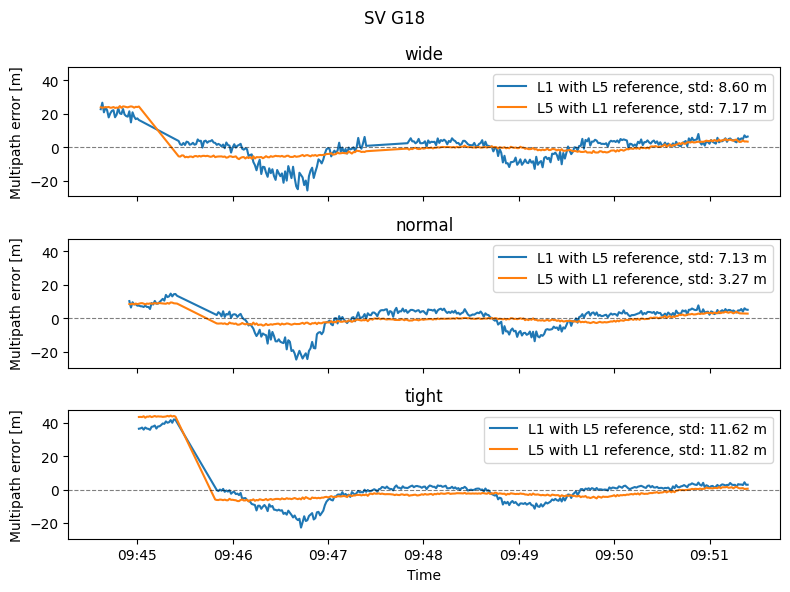

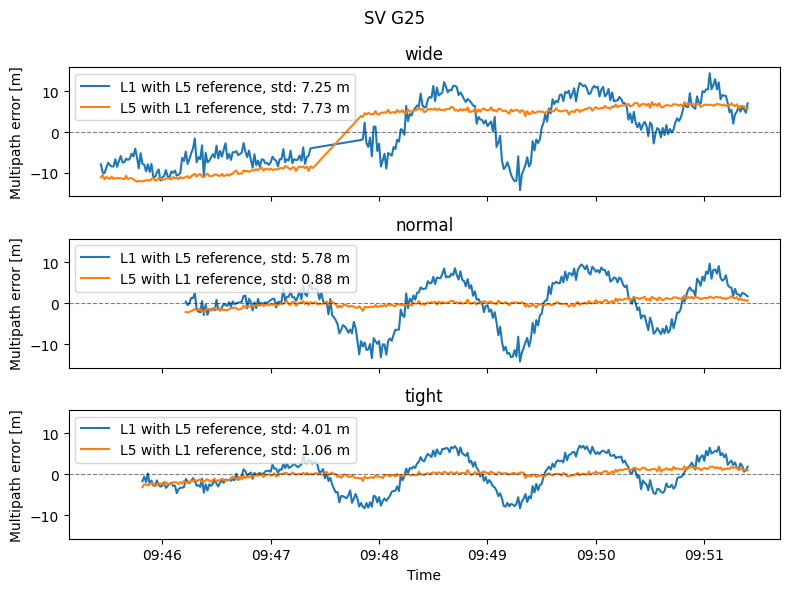

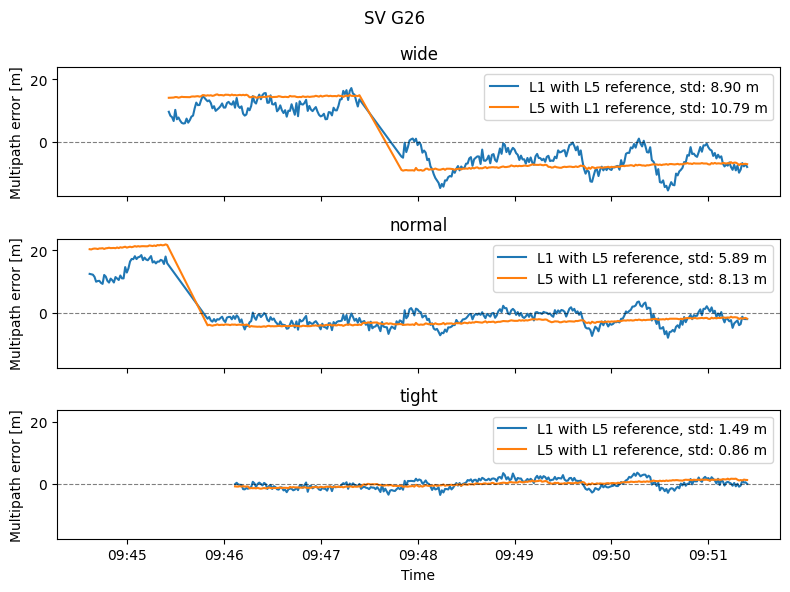

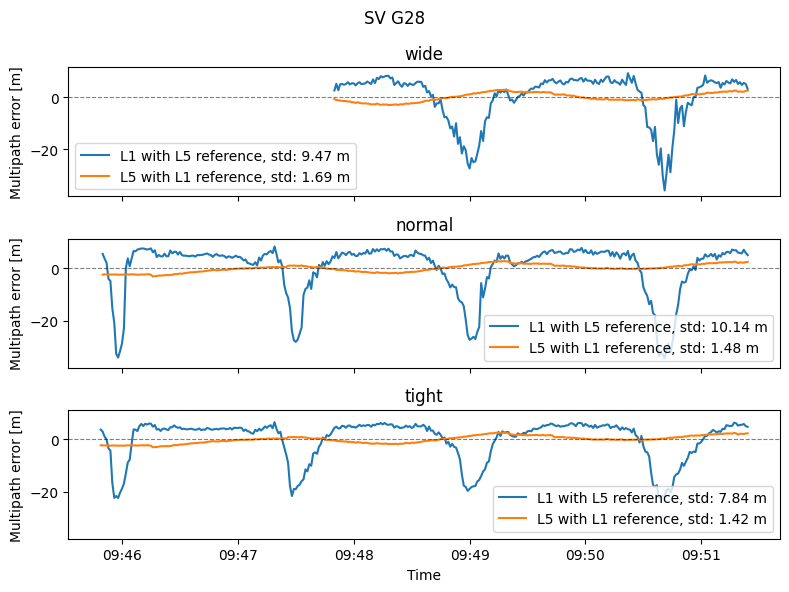

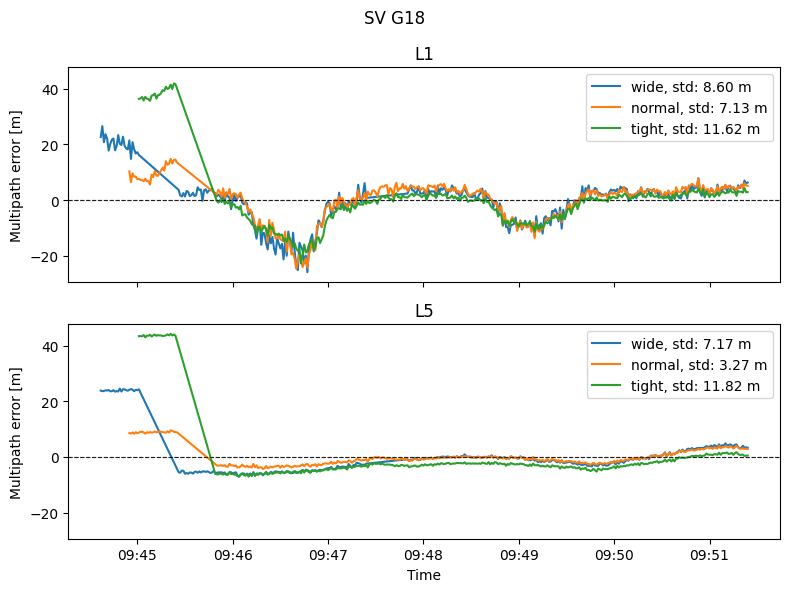

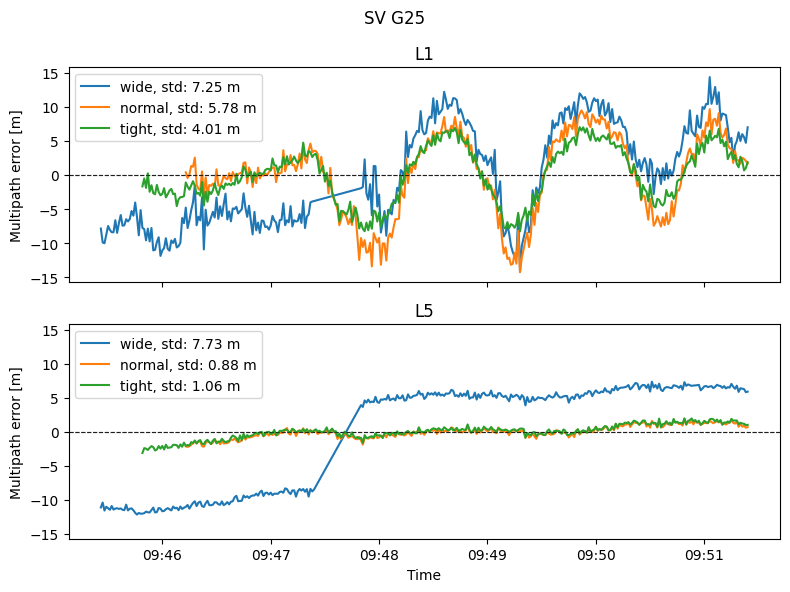

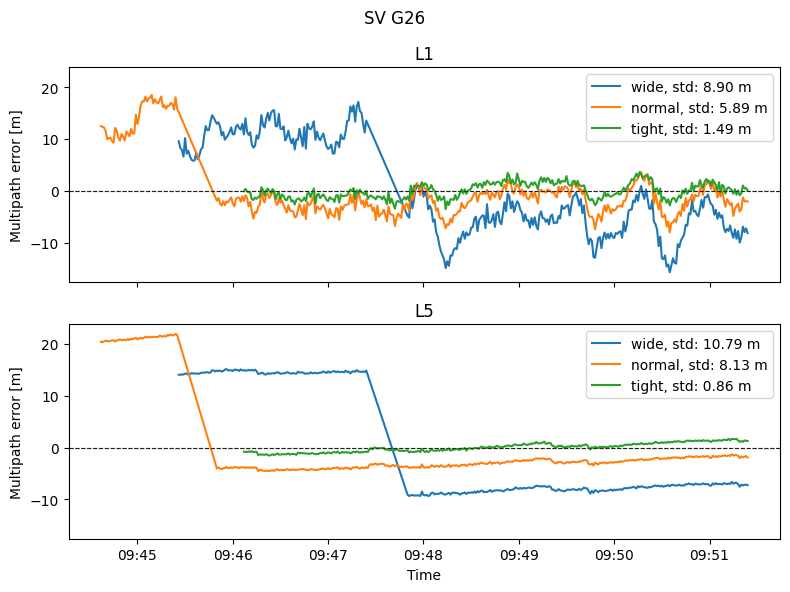

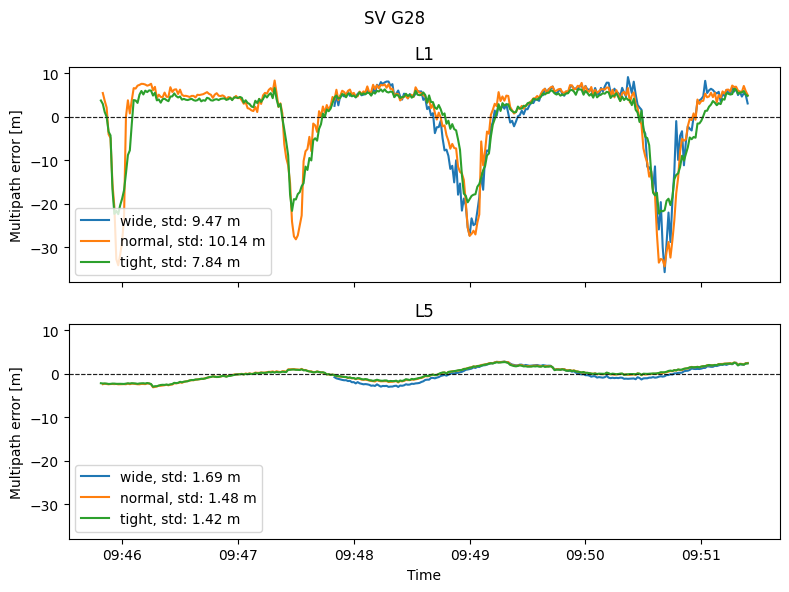

/tmp/ipykernel_14539/3634466893.py:22: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pseudorange_L5)):
/tmp/ipykernel_14539/3634466893.py:22: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pseudorange_L5)):
/tmp/ipykernel_14539/3634466893.py:22: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pseudorange_L5)):


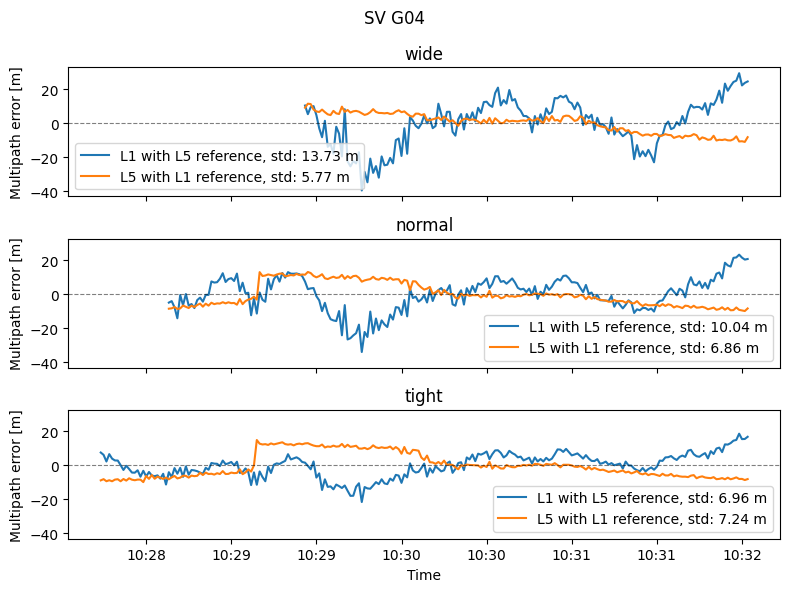

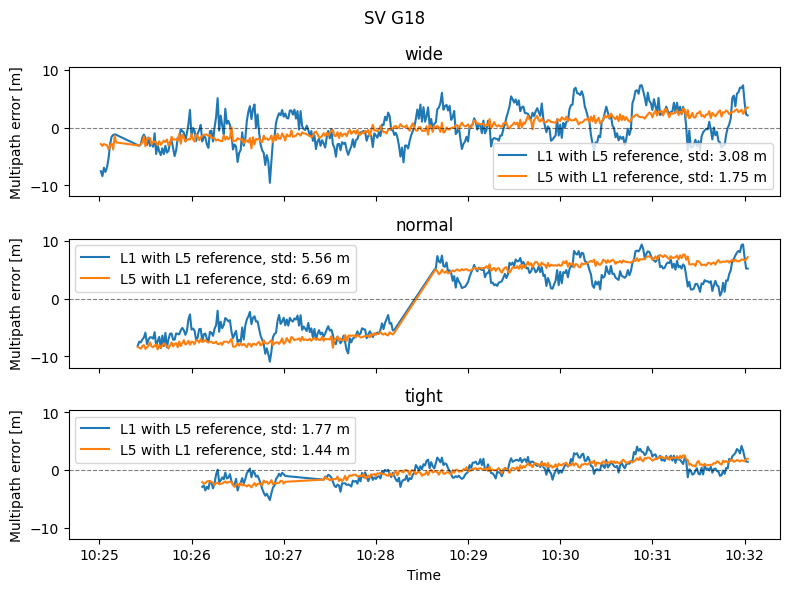

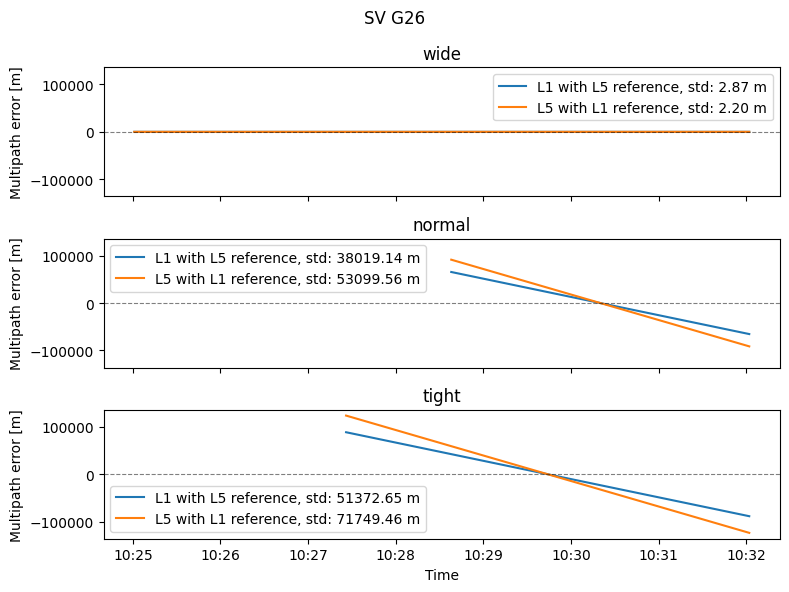

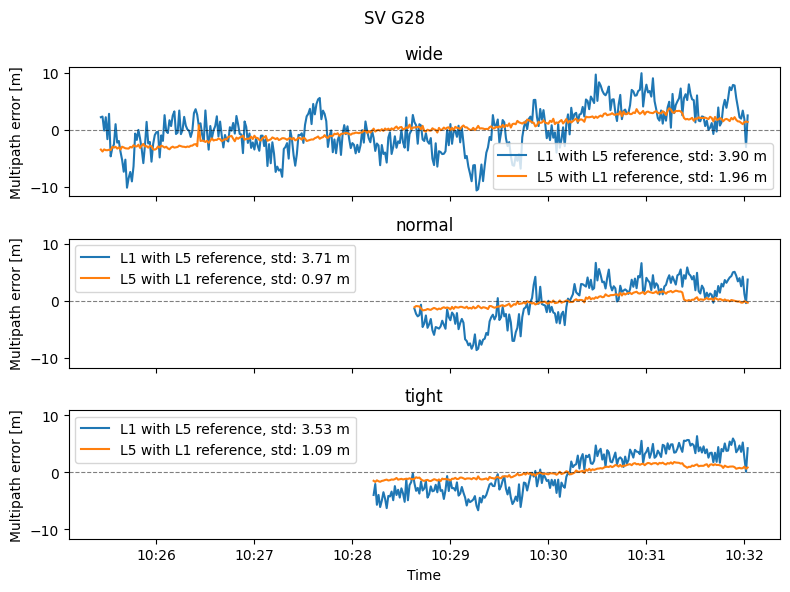

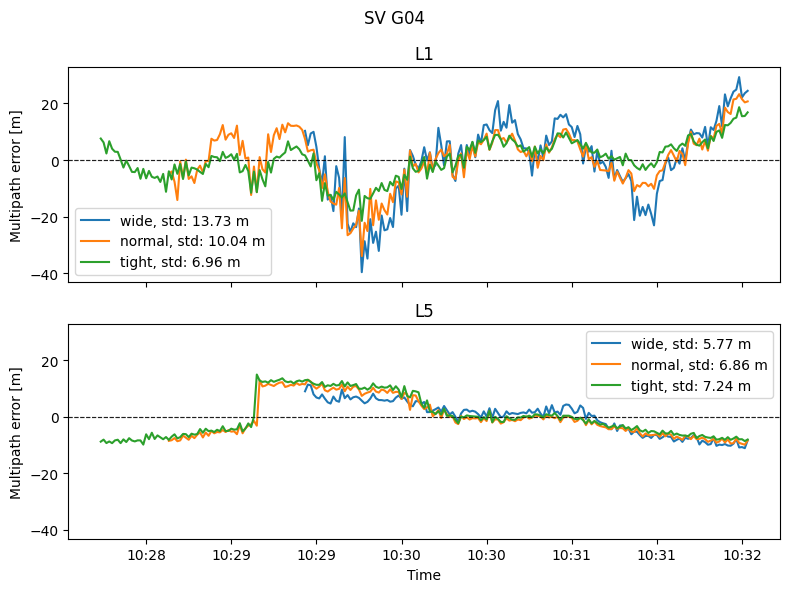

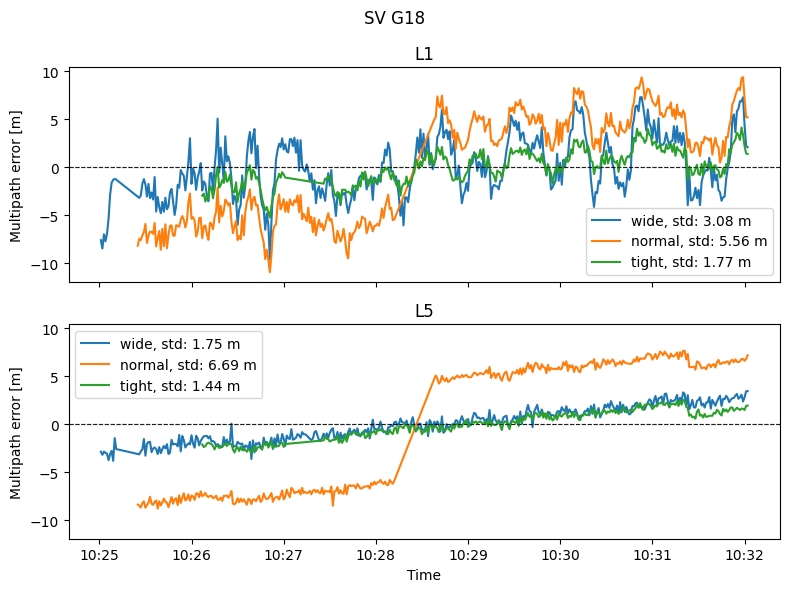

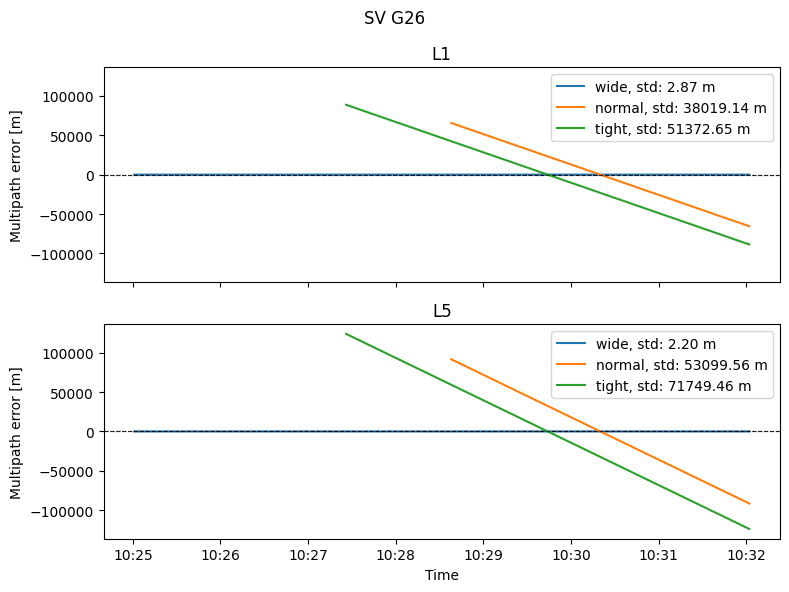

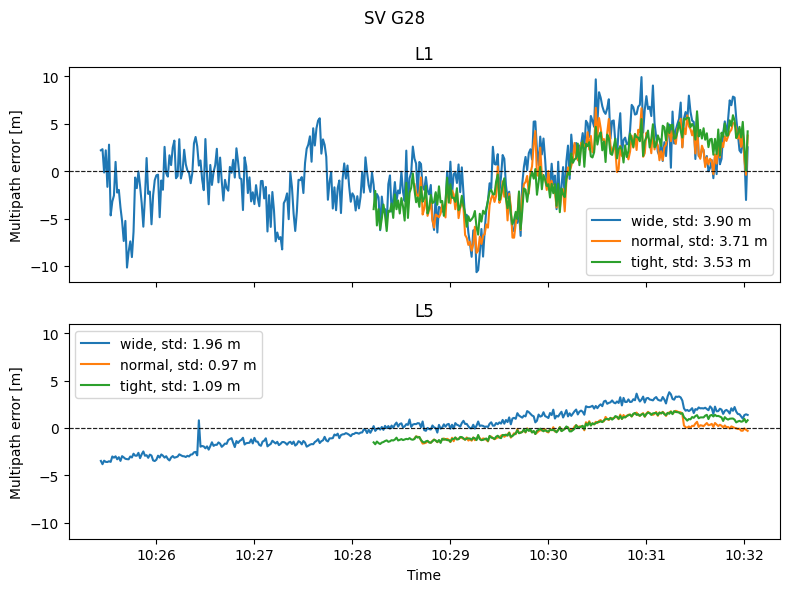

/tmp/ipykernel_14539/3634466893.py:22: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pseudorange_L5)):
/tmp/ipykernel_14539/3634466893.py:22: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pseudorange_L5)):
/tmp/ipykernel_14539/3634466893.py:22: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(pseudorange_L5)):


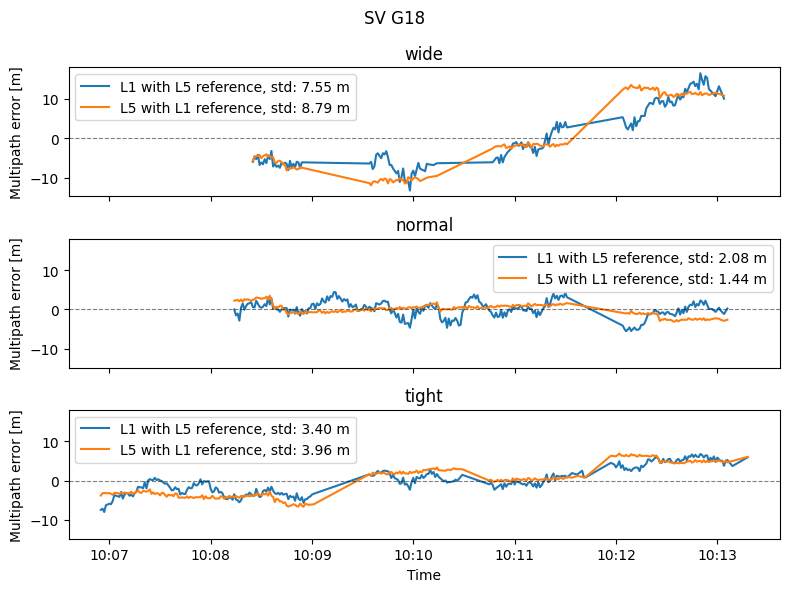

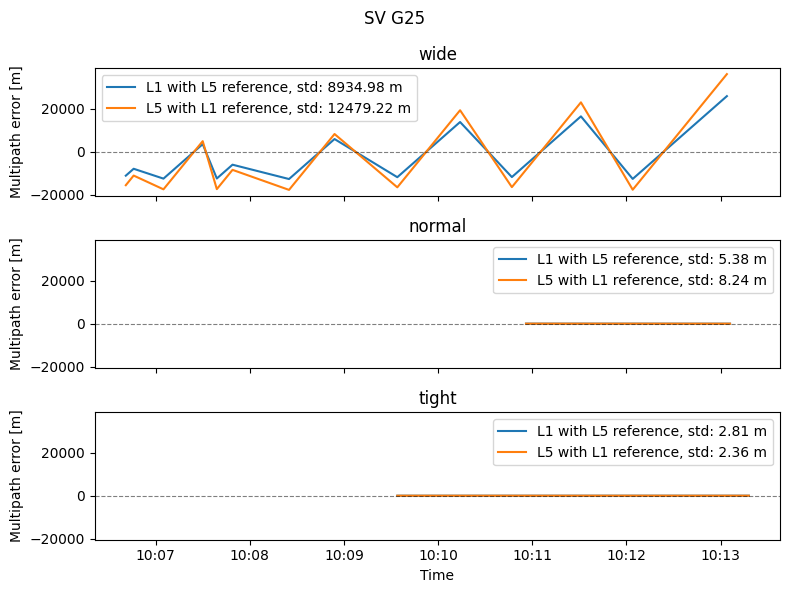

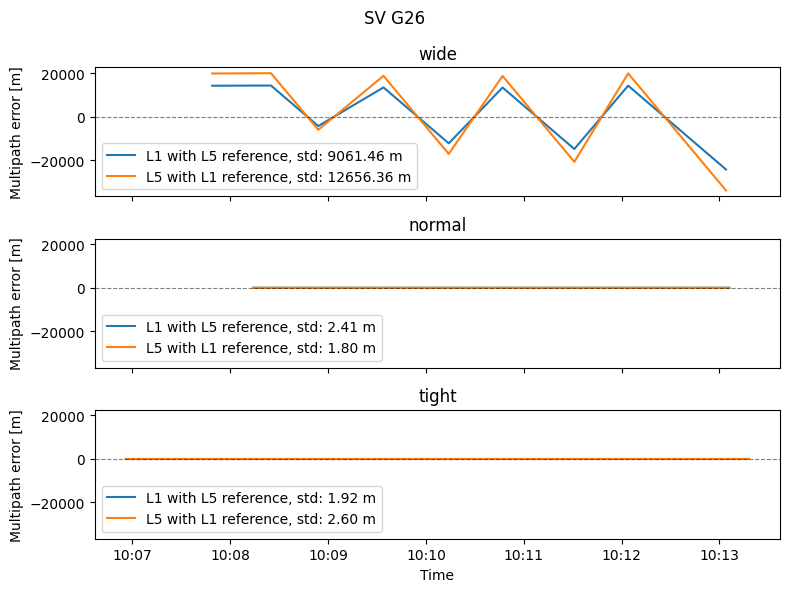

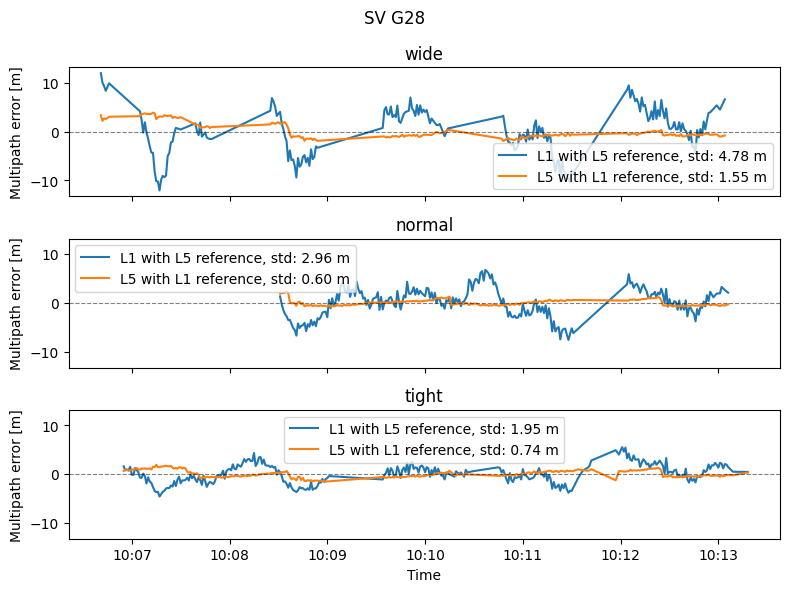

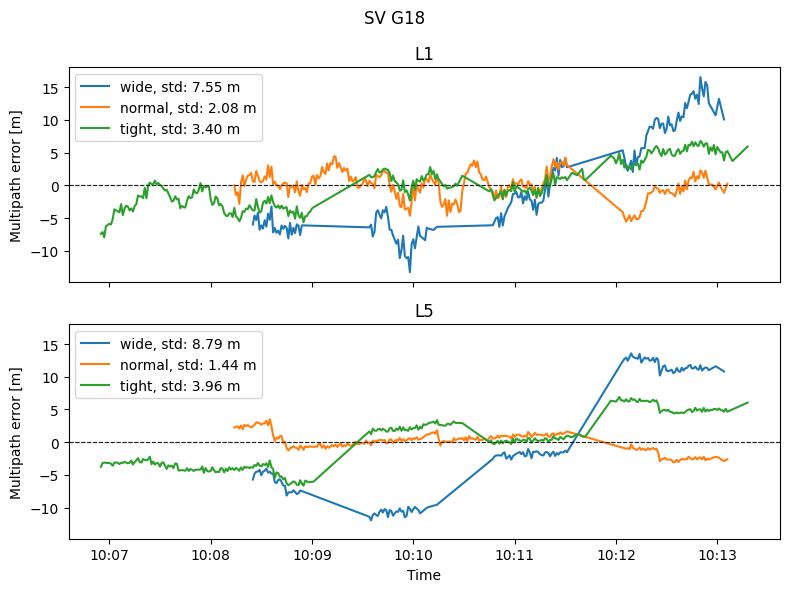

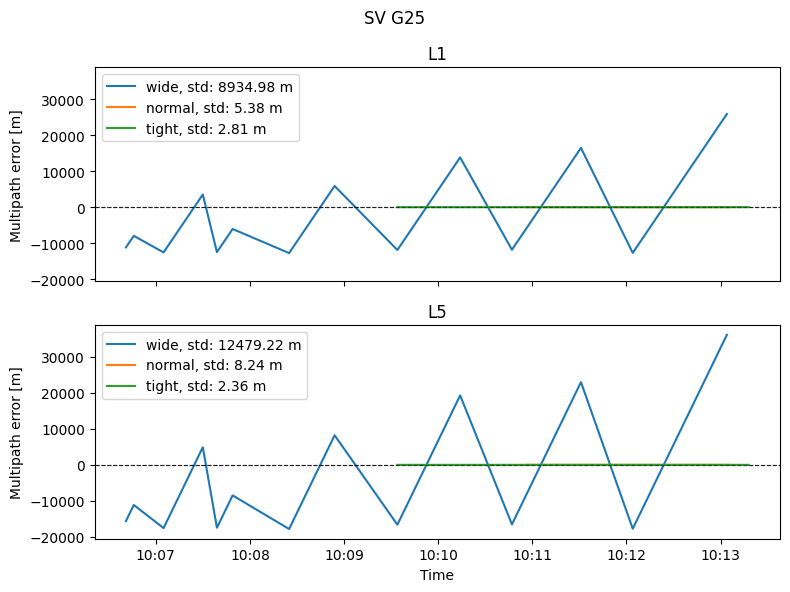

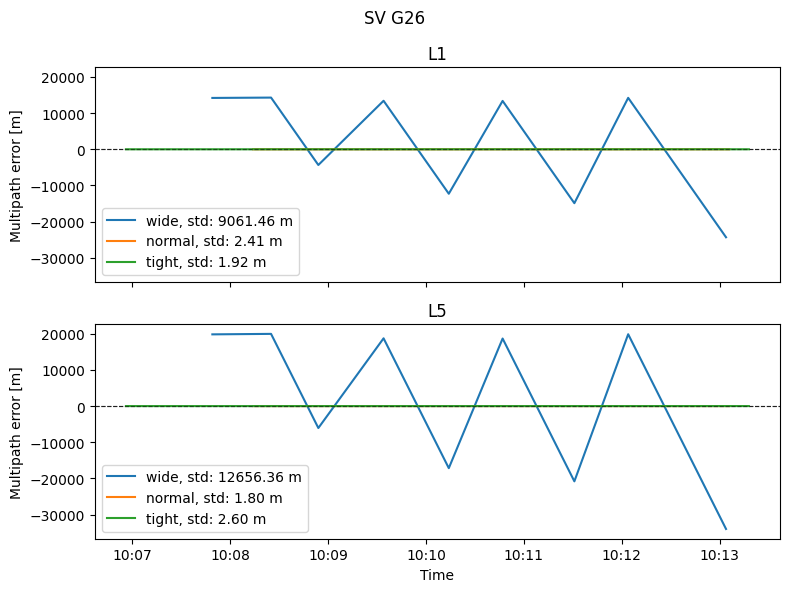

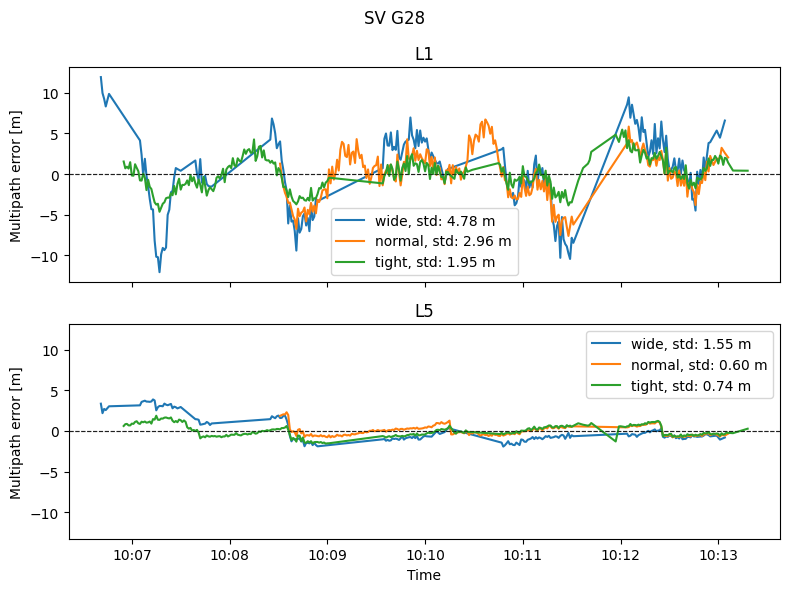

In [321]:
signal = f'L1+L5'
materials = ['clean', 'glass', 'metal', 'brick']
material = materials[0]
chip_settings = ['wide','normal','tight']
for _, material in enumerate(materials):

    mp_errors = {}

    for i, chip_setting in enumerate(chip_settings):
        mp_errors[f'SV_list_{chip_setting}'] = []
        date = return_date(chip_setting, material)
        obs_file = f'{date}.24O'
        chip_spacing = get_chip_spacing(chip_setting)

        path = f'../software_receiver/GNSS-SDR/data/{signal}/{material}/{chip_spacing}/'
        obs = gr.load(path+obs_file)

        sv_list = obs.sv.values
        for _, sv in enumerate(sv_list):
            pseudorange_L1 = obs.sel(sv=sv)[pseudorange_L1_selector].values
            pseudorange_L5 = obs.sel(sv=sv)[pseudorange_L5_selector].values
            if np.isnan(np.nanmean(pseudorange_L5)):
                continue
            carrier_phase_L1 = obs.sel(sv=sv)[carrier_phase_L1_selector].values
            carrier_phase_L5 = obs.sel(sv=sv)[carrier_phase_L5_selector].values
            L1L5mp = calculate_multipath_error(pseudorange_L1, freq_L1, carrier_phase_L1, freq_L5, carrier_phase_L5)
            L5L1mp = calculate_multipath_error(pseudorange_L5, freq_L5, carrier_phase_L5, freq_L1, carrier_phase_L1)
            mp_errors[f'SV_list_{chip_setting}'] += [sv]
            mp_errors[f'{sv}_L1L5mp_{chip_setting}'] = L1L5mp
            mp_errors[f'{sv}_L5L1mp_{chip_setting}'] = L5L1mp

    for i, chip_setting in enumerate(chip_settings):
        exec(f'sv_list_{chip_setting} = mp_errors[f"SV_list_{chip_setting}"]')

    sv_list = [sv for sv in sv_list_normal if sv in sv_list_tight and sv_list_normal]

    for i, sv in enumerate(sv_list):
        fig,ax = plt.subplots(len(chip_settings), sharex=True, sharey=True, figsize=(8,6))
        fig.suptitle(f'SV {sv}')
        for j, chip_setting in enumerate(chip_settings):

            date = return_date(chip_setting, material)
            obs_file = f'{date}.24O'
            chip_spacing = get_chip_spacing(chip_setting)
            path = f'../software_receiver/GNSS-SDR/data/{signal}/{material}/{chip_spacing}/'

            obs = gr.load(path+obs_file)
            ax[j].plot(obs.sel(sv=sv).time.values,mp_errors[f'{sv}_L1L5mp_{chip_setting}'],label=f'L1 with L5 reference, std: {np.nanstd(mp_errors[f"{sv}_L1L5mp_{chip_setting}"]):.2f} m')
            ax[j].plot(obs.sel(sv=sv).time.values,mp_errors[f'{sv}_L5L1mp_{chip_setting}'],label=f'L5 with L1 reference, std: {np.nanstd(mp_errors[f"{sv}_L5L1mp_{chip_setting}"]):.2f} m')
            ax[j].axhline(y=0, linestyle='--', linewidth=0.8, color='black', alpha=0.5)
            ax[j].legend()
            ax[j].set_ylabel('Multipath error [m]')
            ax[j].set_title(chip_setting)
            ax[2].set_xlabel('Time')
            ax[2].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
        plt.tight_layout()
        plt.savefig(f'../figs/multipath_errors/gnss_sdr/{material}/{material}_gnss_sdr_{sv}_mp_errors_chip_separated.pdf')
        plt.savefig(f'../figs/multipath_errors/gnss_sdr/{material}/{material}_gnss_sdr_{sv}_mp_errors_chip_separated.png')
        plt.show()

    mp_frequencies = ['L1L5', 'L5L1']

    for i, sv in enumerate(sv_list):
        fig,ax = plt.subplots(len(mp_frequencies), sharex=True, sharey=True, figsize=(8,6))
        fig.suptitle(f'SV {sv}')
        for j, chip_setting in enumerate(chip_settings):
            date = return_date(chip_setting, material)
            obs_file = f'{date}.24O'
            chip_spacing = get_chip_spacing(chip_setting)
            path = f'../software_receiver/GNSS-SDR/data/{signal}/{material}/{chip_spacing}/'

            obs = gr.load(path+obs_file)
            for k, mp_frequency in enumerate(mp_frequencies):
                ax[k].plot(obs.sel(sv=sv).time.values,mp_errors[f'{sv}_{mp_frequency}mp_{chip_setting}'],label=f'{chip_setting}, std: {np.nanstd(mp_errors[f"{sv}_{mp_frequency}mp_{chip_setting}"]):.2f} m')
                ax[k].axhline(y=0, linestyle='--', linewidth=0.8, color='black', alpha=0.5)
                ax[k].legend()
                ax[k].set_ylabel('Multipath error [m]')
                ax[k].set_title(f'{mp_frequency[:2]}')
            ax[1].set_xlabel('Time')
            ax[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
        plt.tight_layout()
        plt.savefig(f'../figs/multipath_errors/gnss_sdr/{material}/{material}_gnss_sdr_{sv}_mp_errors_frequency_separated.pdf')
        plt.savefig(f'../figs/multipath_errors/gnss_sdr/{material}/{material}_gnss_sdr_{sv}_mp_errors_frequency_separated.png')
        plt.show()
    plt.close('all')


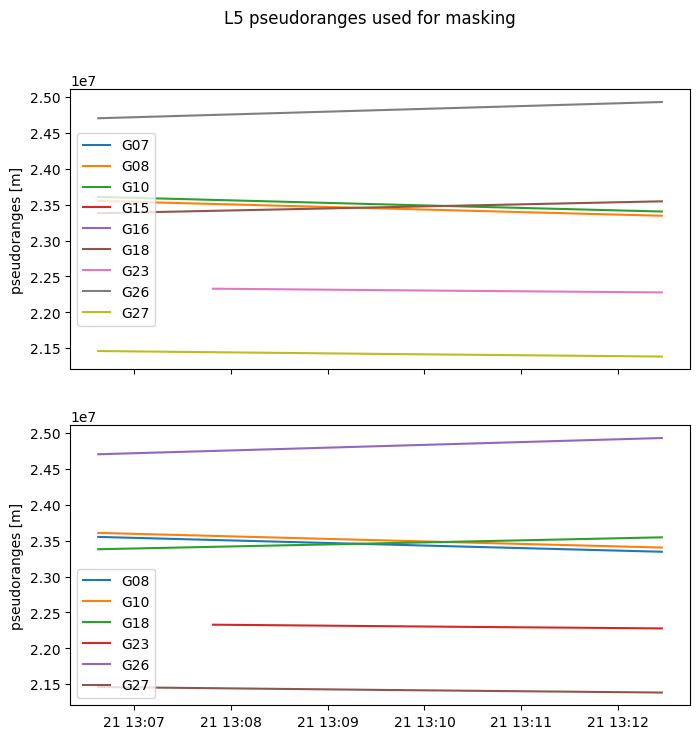

In [316]:
len_of_t = len(obs_main.time.values)

sv_list = obs_main.sv.values
condition = len_of_t//1
sv_selector = np.array(np.sum(np.isnan(obs_main.sel(sv=sv_list)[pseudorange_L5_selector].values),axis=0)<condition)
sv_list = sv_list[sv_selector]

if USE_L1:
    pseudoranges_L1 = obs_main.sel(sv=sv_list)[pseudorange_L1_selector].values
if USE_L2:
    pseudoranges_L2 = obs_main.sel(sv=sv_list)[pseudorange_L2_selector].values
if USE_L5:
    pseudoranges_L5 = obs_main.sel(sv=sv_list)[pseudorange_L5_selector].values

fig, ax = plt.subplots(2,1,figsize=(8,8),sharex=True)
fig.suptitle('L5 pseudoranges used for masking')
for _, sv in enumerate(obs_main.sv.values):
    ax[0].plot(obs_main[pseudorange_L1_selector].sel(sv=sv).time.values,obs_main.sel(sv=sv)[pseudorange_L5_selector].values, label=f'{sv}')
ax[0].set_ylabel('pseudoranges [m]')
ax[0].legend()
for idx, sv in enumerate(sv_list):
    ax[1].plot(obs_main[pseudorange_L1_selector].sel(sv=sv).time.values,pseudoranges_L5[:,idx],label=f'{sv}')
ax[1].set_ylabel('pseudoranges [m]')
ax[1].legend()
plt.show()

In [317]:
SAASTAMOINEN_CORRECTION = False # not used - will look at median position calculated and compare with that to not interrupt the direct signal received
KLOBUCHAR_CORRECTION = False # not used - will look at median position calculated and compare with that to not interrupt the direct signal received
IONOSPHERIC_FREE_COMBINATION_CORRECTION = False # not applicable for now (not useful for multipath detection)
MULTIPATH_CORRECTION = False # doesn't seem to work with pseudoranges :)

# initialize 
if USE_L1:
    sat_positions_L1 = np.zeros((len(sv_list),3,len_of_t))
    sat_clock_relativistic_correction_L1 = np.zeros((len(sv_list), len_of_t))
    az_L1 = np.zeros((len(sv_list),len_of_t))
    el_L1 = np.zeros_like(az_L1)
if USE_L2:
    sat_positions_L2 = np.zeros((len(sv_list),3,len_of_t))
    sat_clock_relativistic_correction_L2 = np.zeros((len(sv_list), len_of_t))
    az_L2 = np.zeros((len(sv_list),len_of_t))
    el_L2 = np.zeros_like(az_L2)
if USE_L5:
    sat_positions_L5 = np.zeros((len(sv_list),3,len_of_t))
    sat_clock_relativistic_correction_L5 = np.zeros((len(sv_list), len_of_t))
    az_L5 = np.zeros((len(sv_list),len_of_t))
    el_L5 = np.zeros_like(az_L5)


R_L = R1(90-true_pos_lla[0],deg=True)@R3(true_pos_lla[1]+90,deg=True)

## computing
for t_i in tqdm(range(len_of_t), desc="Progress", leave=False):
    # calculate satellite positions

    _, tow = datetime_to_gpsweek(obs_main.time.values[t_i])
    for j in range(len(sv_list)):
        if USE_L1:
            sat_pos, _, sat_clock_relativistic_correction_L1[j,t_i] = calcSatPos(nav_main, tow-pseudoranges_L1[t_i,j]/c, sv_list[j], True)
            sat_positions_L1[j,:,t_i] = earth_rotation_correction(pseudoranges_L1[t_i,j]/c + sat_clock_relativistic_correction_L1[j,t_i], sat_pos.T)

            sat_ENU = (R_L @ (sat_positions_L1[j,:,t_i].reshape((-1,1)) - true_pos_ecef.reshape((-1,1))))
            # calculate azimuth and zenith
            azimuth = np.arctan2(sat_ENU[0], sat_ENU[1])
            azimuth = np.rad2deg(azimuth[0])
            zenith = np.arccos(sat_ENU[2] / np.sqrt(sat_ENU[0]**2 + sat_ENU[1]**2 + sat_ENU[2]**2))  
            zenith = np.rad2deg(zenith[0])

            if azimuth < 0:
                azimuth = 360 + azimuth

            if ((90-zenith) > 0):
                az_L1[j,t_i] = azimuth
                el_L1[j,t_i] = 90-zenith
            else:
                az_L1[j,t_i] = np.nan
                el_L1[j,t_i] = np.nan
        if USE_L2:
            sat_pos, _, sat_clock_relativistic_correction_L2[j,t_i] = calcSatPos(nav_main, tow-pseudoranges_L2[t_i,j]/c, sv_list[j], use_iono_free_correction=IONOSPHERIC_FREE_COMBINATION_CORRECTION,)
            sat_positions_L2[j,:,t_i] = earth_rotation_correction(pseudoranges_L2[t_i,j]/c + sat_clock_relativistic_correction_L2[j,t_i], sat_pos.T)

            sat_ENU = (R_L @ (sat_positions_L2[j,:,t_i].reshape((-1,1)) - true_pos_ecef.reshape((-1,1))))
            # calculate azimuth and zenith
            azimuth = np.arctan2(sat_ENU[0], sat_ENU[1])
            azimuth = np.rad2deg(azimuth[0])
            zenith = np.arccos(sat_ENU[2] / np.sqrt(sat_ENU[0]**2 + sat_ENU[1]**2 + sat_ENU[2]**2))  
            zenith = np.rad2deg(zenith[0])

            if azimuth < 0:
                azimuth = 360 + azimuth

            if ((90-zenith) > 0):
                az_L2[j,t_i] = azimuth
                el_L2[j,t_i] = 90-zenith
            else:
                az_L2[j,t_i] = np.nan
                el_L2[j,t_i] = np.nan
        if USE_L5:
            sat_pos, _, sat_clock_relativistic_correction_L5[j,t_i] = calcSatPos(nav_main, tow-pseudoranges_L5[t_i,j]/c, sv_list[j], True)
            sat_positions_L5[j,:,t_i] = earth_rotation_correction(pseudoranges_L5[t_i,j]/c + sat_clock_relativistic_correction_L5[j,t_i], sat_pos.T)

            sat_ENU = (R_L @ (sat_positions_L5[j,:,t_i].reshape((-1,1)) - true_pos_ecef.reshape((-1,1))))
            # calculate azimuth and zenith
            azimuth = np.arctan2(sat_ENU[0], sat_ENU[1])
            azimuth = np.rad2deg(azimuth[0])
            zenith = np.arccos(sat_ENU[2] / np.sqrt(sat_ENU[0]**2 + sat_ENU[1]**2 + sat_ENU[2]**2))  
            zenith = np.rad2deg(zenith[0])

            if azimuth < 0:
                azimuth = 360 + azimuth

            if ((90-zenith) > 0):
                az_L5[j,t_i] = azimuth
                el_L5[j,t_i] = 90-zenith
            else:
                az_L5[j,t_i] = np.nan
                el_L5[j,t_i] = np.nan


In [318]:
if USE_L1:
    calculated_position_L1 = np.zeros((len_of_t, 3)) * np.nan
if USE_L2:
    calculated_position_L2 = np.zeros((len_of_t, 3)) * np.nan
if USE_L5:
    calculated_position_L5 = np.zeros((len_of_t, 3)) * np.nan

clock_error = np.zeros((len_of_t,3))

for t_i in range(len_of_t):
    conditions = []
    if USE_L1:
        conditions.append(~np.isnan(pseudoranges_L1[t_i]))
    if USE_L2:
        conditions.append(~np.isnan(pseudoranges_L2[t_i]))
    if USE_L5:
        conditions.append(~np.isnan(pseudoranges_L5[t_i]))
    
    if conditions:
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition &= condition
        nan_idx = np.where(combined_condition)[0]
    else:
        nan_idx = np.array([])

    if len(nan_idx) < 4:
        continue
    
    if USE_L1:
        try:
            calculated_position_L1[t_i], clock_error[t_i,0] = least_squares_pseudoranges(pseudoranges_L1[t_i,nan_idx]+c*sat_clock_relativistic_correction_L1[nan_idx,t_i], sat_positions_L1[nan_idx,:,t_i], iter_max=25)
        except np.linalg.LinAlgError as err:
            calculated_position_L1[t_i], clock_error[t_i,1] = np.array([np.nan,np.nan,np.nan]), np.nan
    if USE_L2:
        try:
            calculated_position_L2[t_i], clock_error[t_i,1] = least_squares_pseudoranges(pseudoranges_L2[t_i,nan_idx]+c*sat_clock_relativistic_correction_L2[nan_idx,t_i], sat_positions_L2[nan_idx,:,t_i], iter_max=25)
        except np.linalg.LinAlgError as err:
            calculated_position_L2[t_i], clock_error[t_i,1] = np.array([np.nan,np.nan,np.nan]), np.nan
    if USE_L5:
        try:
            calculated_position_L5[t_i], clock_error[t_i,2] = least_squares_pseudoranges(pseudoranges_L5[t_i,nan_idx]+c*sat_clock_relativistic_correction_L5[nan_idx,t_i], sat_positions_L5[nan_idx,:,t_i], iter_max=25)
        except np.linalg.LinAlgError as err:
            calculated_position_L5[t_i], clock_error[t_i,1] = np.array([np.nan,np.nan,np.nan]), np.nan


if USE_L1:
    diff_L1_true_pos = np.zeros(len(calculated_position_L1)) * np.nan
    diff_L1_median_pos = np.zeros_like(diff_L1_true_pos) * np.nan
    for i in range(len(calculated_position_L1)):
        diff_L1_true_pos[i] = np.linalg.norm(true_pos_ecef - calculated_position_L1[i])

if USE_L2:
    diff_L2_true_pos = np.zeros(len(calculated_position_L2)) * np.nan
    diff_L2_median_pos = np.zeros_like(diff_L2_true_pos) * np.nan
    for i in range(len(calculated_position_L2)):
        diff_L2_true_pos[i] = np.linalg.norm(true_pos_ecef - calculated_position_L2[i])

if USE_L5:
    diff_L5_true_pos = np.zeros(len(calculated_position_L5)) * np.nan
    diff_L5_median_pos = np.zeros_like(diff_L5_true_pos) * np.nan
    for i in range(len(calculated_position_L5)):
        diff_L5_true_pos[i] = np.linalg.norm(true_pos_ecef - calculated_position_L5[i])

calculated_positions = []
if USE_L1:
    calculated_positions.append(calculated_position_L1)
if USE_L2:
    calculated_positions.append(calculated_position_L2)
if USE_L5:
    calculated_positions.append(calculated_position_L5)

calculated_position = np.vstack(calculated_positions)

for i in range(len(calculated_position_L1)):
    if USE_L1:
        diff_L1_median_pos[i] = np.linalg.norm(np.nanmedian(calculated_position,axis=0) - calculated_position_L1[i])
    if USE_L2:
        diff_L2_median_pos[i] = np.linalg.norm(np.nanmedian(calculated_position,axis=0) - calculated_position_L2[i])
    if USE_L5:
        diff_L5_median_pos[i] = np.linalg.norm(np.nanmedian(calculated_position,axis=0) - calculated_position_L5[i])

/tmp/ipykernel_14539/2736499471.py:66: RuntimeWarning: Mean of empty slice
  mean_of_mean = np.nanmean(mean_value_L5_backward[i:])
/tmp/ipykernel_14539/2736499471.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([np.datetime_as_string(decimal_year_to_datetime(ticks), unit='h')[-2:] + ':' + np.datetime_as_string(decimal_year_to_datetime(ticks), unit='m')[-2:] for ticks in all_xticks])


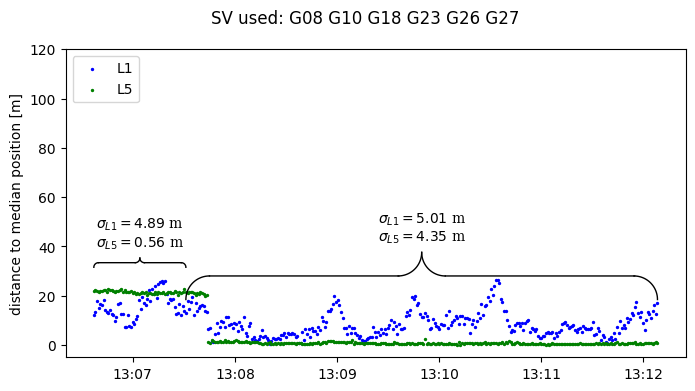

In [319]:
threshold_distance = 1000
idx_over_distance_threshold = np.where(diff_L1_median_pos>threshold_distance)

if idx_over_distance_threshold:
    diff_L1_median_pos[idx_over_distance_threshold[0]] = np.nan

idx_over_distance_threshold = np.where(diff_L5_median_pos>threshold_distance)

if idx_over_distance_threshold:
    diff_L5_median_pos[idx_over_distance_threshold[0]] = np.nan

def diff_with_padding(arr):
    """Perform differencing with padding to maintain the same dimensions."""
    diff_result = np.diff(arr)
    padded_diff = np.concatenate(([np.nan], diff_result))
    return padded_diff

def moving_average(data, window_size=100):
    """Compute the moving average of a signal."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

idx_for_braces = []
for i in range(len(obs_main.time.values[np.where(~np.isnan(diff_L5_median_pos))[0]])-1):
    idx = np.where(~np.isnan(diff_L5_median_pos))[0][i]
    time_diff = obs_main.time.values[idx+1] - obs_main.time.values[idx]
    threshold = np.timedelta64(3,'s')
    if time_diff > threshold:
        idx_for_braces.append(idx)

if not idx_for_braces:
    run_mean_estimations = True
else:
    run_mean_estimations = False


if run_mean_estimations:
    mean_value_L5_forward = np.zeros_like(diff_L5_median_pos) * np.nan
    for i in range(1,len(diff_L5_median_pos)-1):
        mean_value_L5_forward[i-1] = np.nanmean(diff_L5_median_pos[0:i])
    mean_value_L5_backward = np.zeros_like(diff_L5_median_pos) * np.nan
    for i in range(len(diff_L5_median_pos)-1,1,-1):
        mean_value_L5_backward[i-1] = np.nanmean(diff_L5_median_pos[i:])
        if np.isnan(diff_L5_median_pos[i]):
            break

    mean_value_L1_forward = np.zeros_like(diff_L1_median_pos) * np.nan
    for i in range(1,len(diff_L1_median_pos)-1):
        mean_value_L1_forward[i-1] = np.nanmean(diff_L1_median_pos[0:i])
    mean_value_L1_backward = np.zeros_like(diff_L1_median_pos) * np.nan
    for i in range(len(diff_L1_median_pos)-1,1,-1):
        mean_value_L1_backward[i-1] = np.nanmean(diff_L1_median_pos[i:])

    idx_forward = np.nan
    threshold_forward = 1
    while np.isnan(idx_forward):
        for i in range(1,len(mean_value_L5_forward)):
            mean_of_mean = np.nanmean(mean_value_L5_forward[0:i])
            if np.abs(mean_value_L5_forward[i] - mean_of_mean) > threshold_forward:
                idx_forward = i
                break
        threshold_forward -= 0.01
    idx_backward = np.nan
    threshold_backward = threshold_forward
    while np.isnan(idx_backward):
        for i in range(len(mean_value_L5_backward)-1,1,-1):
            mean_of_mean = np.nanmean(mean_value_L5_backward[i:])
            if np.abs(mean_value_L5_backward[i-1] - mean_of_mean) > threshold_backward:
                idx_backward = i
                break
        threshold_backward -= 0.01


fig,ax = plt.subplots(1,figsize=(8,4))
fig.suptitle(f'SV used: {" ".join([s for s in sv_list])}')
if curly_brace_bool:
    ax.scatter(datetime_to_decyear(obs_main.time.values), diff_L1_median_pos, s=2, color='blue', label=f'L1')
    ax.scatter(datetime_to_decyear(obs_main.time.values), diff_L5_median_pos, s=2, color='green', label=f'L5')
else:
    ax.scatter(datetime_to_decyear(obs_main.time.values), diff_L1_median_pos, s=2, color='blue', label=f'L1, $\sigma_{{L1}}={np.nanstd(diff_L1_median_pos):.2f}$ m')
    ax.scatter(datetime_to_decyear(obs_main.time.values), diff_L5_median_pos, s=2, color='green', label=f'L5, $\sigma_{{L5}}={np.nanstd(diff_L5_median_pos):.2f}$ m')
ax.legend(loc='upper left')
if material == 'glass':
    ax.set_ylim([-5, 1500])
else:
    ax.set_ylim([-5, 120])
ax.set_ylabel(f'distance to median position [m]')

first_pos_idx = np.where(~np.isnan(diff_L5_median_pos))[0][0]
if idx_for_braces:
    idx_for_brace_end = idx_for_braces[0] 
else:
    idx_for_brace_end = idx_backward


k_r1 = 0.05
lw = 1
brace_color = 'black'
font = {'family': 'serif',
        'color':  'k',
        'style': 'normal',
        'size': 10,
        }
int_line_num = 3
max_value = np.max([np.nanmean(diff_L1_median_pos[first_pos_idx:idx_for_brace_end]),np.nanmean(diff_L5_median_pos[first_pos_idx:idx_for_brace_end])]) + 10

start_time_dec = datetime_to_decyear(obs_main.time.values[first_pos_idx])
end_time_dec = datetime_to_decyear(obs_main.time.values[idx_for_brace_end])
p1 = [start_time_dec, max_value]
p2 = [end_time_dec, max_value]
string_for_brace = f'$\sigma_{{L1}} = {np.nanstd(diff_L1_median_pos[first_pos_idx:idx_for_brace_end]):.2f}$ m\n$\sigma_{{L5}} = {np.nanstd(diff_L5_median_pos[first_pos_idx:idx_for_brace_end]):.2f}$ m'
if curly_brace_bool:
    curlyBrace(fig, ax, p1, p2, k_r1, bool_auto=True, str_text=string_for_brace, color=brace_color, lw=lw, int_line_num=int_line_num, fontdict=font)

if idx_for_braces:
    idx_for_brace_start = idx_for_braces[0] + 1
else:
    idx_for_brace_start = idx_backward

if idx_for_braces:
    if len(idx_for_braces) > 2:
        for i in range(len(idx_for_braces)-1):
            idx_for_brace_start = idx_for_braces[i] + 1
            idx_for_brace_end = idx_for_braces[i+1]
            max_value = np.max([np.nanmean(diff_L1_median_pos[idx_for_brace_start:idx_for_brace_end]),np.nanmean(diff_L5_median_pos[idx_for_brace_start:idx_for_brace_end])]) + 10
            start_time_dec = datetime_to_decyear(obs_main.time.values[idx_for_brace_start])
            end_time_dec = datetime_to_decyear(obs_main.time.values[idx_for_brace_end])
            p1 = [start_time_dec, max_value]
            p2 = [end_time_dec, max_value]
            string_for_brace = f'$\sigma_{{L1}} = {np.nanstd(diff_L1_median_pos[idx_for_brace_start:idx_for_brace_end]):.2f}$ m\n$\sigma_{{L5}} = {np.nanstd(diff_L5_median_pos[idx_for_brace_start:idx_for_brace_end]):.2f}$ m'
            if curly_brace_bool:
                curlyBrace(fig, ax, p1, p2, k_r1, bool_auto=True, str_text=string_for_brace, color=brace_color, lw=lw, int_line_num=int_line_num, fontdict=font)
    else:
        max_value = np.max([np.nanmean(diff_L1_median_pos[idx_for_brace_start:-1]),np.nanmean(diff_L5_median_pos[idx_for_brace_start:-1])]) + 10
        start_time_dec = datetime_to_decyear(obs_main.time.values[idx_for_brace_start])
        end_time_dec = datetime_to_decyear(obs_main.time.values[-1])
        p1 = [start_time_dec, max_value]
        p2 = [end_time_dec, max_value]
        string_for_brace = f'$\sigma_{{L1}} = {np.nanstd(diff_L1_median_pos[idx_for_brace_start:-1]):.2f}$ m\n$\sigma_{{L5}} = {np.nanstd(diff_L5_median_pos[idx_for_brace_start:-1]):.2f}$ m'
        if curly_brace_bool:
            curlyBrace(fig, ax, p1, p2, k_r1, bool_auto=True, str_text=string_for_brace, color=brace_color, lw=lw, int_line_num=int_line_num, fontdict=font)
else:
    max_value = np.max([np.nanmean(diff_L1_median_pos[idx_for_brace_start:-1]),np.nanmean(diff_L5_median_pos[idx_for_brace_start:-1])]) + 10
    start_time_dec = datetime_to_decyear(obs_main.time.values[idx_for_brace_start])
    end_time_dec = datetime_to_decyear(obs_main.time.values[-1])
    p1 = [start_time_dec, max_value]
    p2 = [end_time_dec, max_value]
    string_for_brace = f'$\sigma_{{L1}} = {np.nanstd(diff_L1_median_pos[idx_for_brace_start:-1]):.2f}$ m\n$\sigma_{{L5}} = {np.nanstd(diff_L5_median_pos[idx_for_brace_start:-1]):.2f}$ m'
    if curly_brace_bool:
        curlyBrace(fig, ax, p1, p2, k_r1, bool_auto=True, str_text=string_for_brace, color=brace_color, lw=lw, int_line_num=int_line_num, fontdict=font)


all_xticks = ax.get_xticks()
ax.set_xticklabels([np.datetime_as_string(decimal_year_to_datetime(ticks), unit='h')[-2:] + ':' + np.datetime_as_string(decimal_year_to_datetime(ticks), unit='m')[-2:] for ticks in all_xticks])

plt.savefig(f'../figs/position_calculations/GNSS-SDR/{chip_short}_chips_scatter_{material}_{date}_calculated_position_from_GNSS_SDR.png')
plt.savefig(f'../figs/position_calculations/GNSS-SDR/{chip_short}_chips_scatter_{material}_{date}_calculated_position_from_GNSS_SDR.pdf')

plt.show()



/tmp/ipykernel_14539/4207609872.py:66: RuntimeWarning: Mean of empty slice
  mean_of_mean = np.nanmean(mean_value_L5_backward[i:])
/tmp/ipykernel_14539/4207609872.py:179: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([np.datetime_as_string(decimal_year_to_datetime(ticks), unit='h')[-2:] + ':' + np.datetime_as_string(decimal_year_to_datetime(ticks), unit='m')[-2:] for ticks in all_xticks])


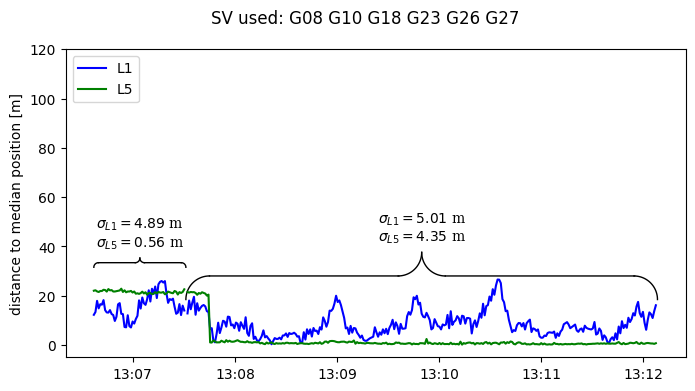

In [320]:
threshold_distance = 1000
idx_over_distance_threshold = np.where(diff_L1_median_pos>threshold_distance)

if idx_over_distance_threshold:
    diff_L1_median_pos[idx_over_distance_threshold[0]] = np.nan

idx_over_distance_threshold = np.where(diff_L5_median_pos>threshold_distance)

if idx_over_distance_threshold:
    diff_L5_median_pos[idx_over_distance_threshold[0]] = np.nan

def diff_with_padding(arr):
    """Perform differencing with padding to maintain the same dimensions."""
    diff_result = np.diff(arr)
    padded_diff = np.concatenate(([np.nan], diff_result))
    return padded_diff

def moving_average(data, window_size=100):
    """Compute the moving average of a signal."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

idx_for_braces = []
for i in range(len(obs_main.time.values[np.where(~np.isnan(diff_L5_median_pos))[0]])-1):
    idx = np.where(~np.isnan(diff_L5_median_pos))[0][i]
    time_diff = obs_main.time.values[idx+1] - obs_main.time.values[idx]
    threshold = np.timedelta64(3,'s')
    if time_diff > threshold:
        idx_for_braces.append(idx)

if not idx_for_braces:
    run_mean_estimations = True
else:
    run_mean_estimations = False


if run_mean_estimations:
    mean_value_L5_forward = np.zeros_like(diff_L5_median_pos) * np.nan
    for i in range(1,len(diff_L5_median_pos)-1):
        mean_value_L5_forward[i-1] = np.nanmean(diff_L5_median_pos[0:i])
    mean_value_L5_backward = np.zeros_like(diff_L5_median_pos) * np.nan
    for i in range(len(diff_L5_median_pos)-1,1,-1):
        mean_value_L5_backward[i-1] = np.nanmean(diff_L5_median_pos[i:])
        if np.isnan(diff_L5_median_pos[i]):
            break

    mean_value_L1_forward = np.zeros_like(diff_L1_median_pos) * np.nan
    for i in range(1,len(diff_L1_median_pos)-1):
        mean_value_L1_forward[i-1] = np.nanmean(diff_L1_median_pos[0:i])
    mean_value_L1_backward = np.zeros_like(diff_L1_median_pos) * np.nan
    for i in range(len(diff_L1_median_pos)-1,1,-1):
        mean_value_L1_backward[i-1] = np.nanmean(diff_L1_median_pos[i:])

    idx_forward = np.nan
    threshold_forward = 1
    while np.isnan(idx_forward):
        for i in range(1,len(mean_value_L5_forward)):
            mean_of_mean = np.nanmean(mean_value_L5_forward[0:i])
            if np.abs(mean_value_L5_forward[i] - mean_of_mean) > threshold_forward:
                idx_forward = i
                break
        threshold_forward -= 0.01
    idx_backward = np.nan
    threshold_backward = threshold_forward
    while np.isnan(idx_backward):
        for i in range(len(mean_value_L5_backward)-1,1,-1):
            mean_of_mean = np.nanmean(mean_value_L5_backward[i:])
            if np.abs(mean_value_L5_backward[i-1] - mean_of_mean) > threshold_backward:
                idx_backward = i
                break
        threshold_backward -= 0.01


decyear_time = datetime_to_decyear(obs_main.time.values)

fig,ax = plt.subplots(1,figsize=(8,4))
fig.suptitle(f'SV used: {" ".join([s for s in sv_list])}')

if curly_brace_bool:
    ax.plot(decyear_time, diff_L1_median_pos, color='blue', alpha=0)
    ax.plot(decyear_time, diff_L5_median_pos, color='green', alpha=0)
else:
    ax.plot(decyear_time, diff_L1_median_pos, color='blue', alpha=0)
    ax.plot(decyear_time, diff_L5_median_pos, color='green', alpha=0)

if material == 'glass':
    ax.set_ylim([-5, 1500])
else:
    ax.set_ylim([-5, 120])
ax.set_ylabel(f'distance to median position [m]')

first_pos_idx = np.where(~np.isnan(diff_L5_median_pos))[0][0]
if idx_for_braces:
    idx_for_brace_end = idx_for_braces[0] 
else:
    idx_for_brace_end = idx_backward


k_r1 = 0.05
lw = 1
brace_color = 'black'
font = {'family': 'serif',
        'color':  'k',
        'style': 'normal',
        'size': 10,
        }
int_line_num = 3
max_value = np.max([np.nanmean(diff_L1_median_pos[first_pos_idx:idx_for_brace_end]),np.nanmean(diff_L5_median_pos[first_pos_idx:idx_for_brace_end])]) + 10

start_time_dec = datetime_to_decyear(obs_main.time.values[first_pos_idx])
end_time_dec = datetime_to_decyear(obs_main.time.values[idx_for_brace_end])
p1 = [start_time_dec, max_value]
p2 = [end_time_dec, max_value]
string_for_brace = f'$\sigma_{{L1}} = {np.nanstd(diff_L1_median_pos[first_pos_idx:idx_for_brace_end]):.2f}$ m\n$\sigma_{{L5}} = {np.nanstd(diff_L5_median_pos[first_pos_idx:idx_for_brace_end]):.2f}$ m'
if curly_brace_bool:
    curlyBrace(fig, ax, p1, p2, k_r1, bool_auto=True, str_text=string_for_brace, color=brace_color, lw=lw, int_line_num=int_line_num, fontdict=font)

if idx_for_braces:
    idx_for_brace_start = idx_for_braces[0] + 1
else:
    idx_for_brace_start = idx_backward

l = 0

if idx_for_braces:
    if len(idx_for_braces) > 2:
        for i in range(len(idx_for_braces)-1):
            idx_for_brace_start = idx_for_braces[i] + 1
            idx_for_brace_end = idx_for_braces[i+1]
            max_value = np.max([np.nanmean(diff_L1_median_pos[idx_for_brace_start:idx_for_brace_end]),np.nanmean(diff_L5_median_pos[idx_for_brace_start:idx_for_brace_end])]) + 10
            start_time_dec = datetime_to_decyear(obs_main.time.values[idx_for_brace_start])
            end_time_dec = datetime_to_decyear(obs_main.time.values[idx_for_brace_end])
            decyear_time = np.insert(decyear_time, idx_for_brace_start+l, np.nan)
            decyear_time = np.insert(decyear_time, idx_for_brace_end+l, np.nan)
            diff_L1_median_pos = np.insert(diff_L1_median_pos, idx_for_brace_start+l, np.nan)
            diff_L1_median_pos = np.insert(diff_L1_median_pos, idx_for_brace_end+l, np.nan)
            diff_L5_median_pos = np.insert(diff_L5_median_pos, idx_for_brace_start+l, np.nan)
            diff_L5_median_pos = np.insert(diff_L5_median_pos, idx_for_brace_end+l, np.nan)
            p1 = [start_time_dec, max_value]
            p2 = [end_time_dec, max_value]
            string_for_brace = f'$\sigma_{{L1}} = {np.nanstd(diff_L1_median_pos[idx_for_brace_start+l:idx_for_brace_end]):.2f}$ m\n$\sigma_{{L5}} = {np.nanstd(diff_L5_median_pos[idx_for_brace_start+l:idx_for_brace_end]):.2f}$ m'
            l += 2
            if curly_brace_bool:
                curlyBrace(fig, ax, p1, p2, k_r1, bool_auto=True, str_text=string_for_brace, color=brace_color, lw=lw, int_line_num=int_line_num, fontdict=font)
    else:
        max_value = np.max([np.nanmean(diff_L1_median_pos[idx_for_brace_start:-1]),np.nanmean(diff_L5_median_pos[idx_for_brace_start:-1])]) + 10
        start_time_dec = datetime_to_decyear(obs_main.time.values[idx_for_brace_start])
        end_time_dec = datetime_to_decyear(obs_main.time.values[-1])
        decyear_time = np.insert(decyear_time, idx_for_brace_start+l, np.nan)
        decyear_time = np.insert(decyear_time, -1, np.nan)
        diff_L1_median_pos = np.insert(diff_L1_median_pos, idx_for_brace_start+l, np.nan)
        diff_L1_median_pos = np.insert(diff_L1_median_pos, idx_for_brace_end+l, np.nan)
        diff_L5_median_pos = np.insert(diff_L5_median_pos, idx_for_brace_start+l, np.nan)
        diff_L5_median_pos = np.insert(diff_L5_median_pos, idx_for_brace_end+l, np.nan)
        l += 1
        p1 = [start_time_dec, max_value]
        p2 = [end_time_dec, max_value]
        string_for_brace = f'$\sigma_{{L1}} = {np.nanstd(diff_L1_median_pos[idx_for_brace_start+l:-1]):.2f}$ m\n$\sigma_{{L5}} = {np.nanstd(diff_L5_median_pos[idx_for_brace_start+l:-1]):.2f}$ m'
        if curly_brace_bool:
            curlyBrace(fig, ax, p1, p2, k_r1, bool_auto=True, str_text=string_for_brace, color=brace_color, lw=lw, int_line_num=int_line_num, fontdict=font)
else:
    max_value = np.max([np.nanmean(diff_L1_median_pos[idx_for_brace_start:-1]),np.nanmean(diff_L5_median_pos[idx_for_brace_start:-1])]) + 10
    start_time_dec = datetime_to_decyear(obs_main.time.values[idx_for_brace_start])
    end_time_dec = datetime_to_decyear(obs_main.time.values[-1])
    decyear_time = np.insert(decyear_time, idx_for_brace_start+l, np.nan)
    decyear_time = np.insert(decyear_time, -1, np.nan)
    diff_L1_median_pos = np.insert(diff_L1_median_pos, idx_for_brace_start+l, np.nan)
    diff_L1_median_pos = np.insert(diff_L1_median_pos, idx_for_brace_end+l, np.nan)
    diff_L5_median_pos = np.insert(diff_L5_median_pos, idx_for_brace_start+l, np.nan)
    diff_L5_median_pos = np.insert(diff_L5_median_pos, idx_for_brace_end+l, np.nan)
    l += 1
    p1 = [start_time_dec, max_value]
    p2 = [end_time_dec, max_value]
    string_for_brace = f'$\sigma_{{L1}} = {np.nanstd(diff_L1_median_pos[idx_for_brace_start:-1]):.2f}$ m\n$\sigma_{{L5}} = {np.nanstd(diff_L5_median_pos[idx_for_brace_start:-1]):.2f}$ m'
    if curly_brace_bool:
        curlyBrace(fig, ax, p1, p2, k_r1, bool_auto=True, str_text=string_for_brace, color=brace_color, lw=lw, int_line_num=int_line_num, fontdict=font)


all_xticks = ax.get_xticks()
ax.set_xticklabels([np.datetime_as_string(decimal_year_to_datetime(ticks), unit='h')[-2:] + ':' + np.datetime_as_string(decimal_year_to_datetime(ticks), unit='m')[-2:] for ticks in all_xticks])

if curly_brace_bool:
    ax.plot(decyear_time, diff_L1_median_pos, color='blue', label=f'L1')
    ax.plot(decyear_time, diff_L5_median_pos, color='green', label=f'L5')
else:
    ax.plot(decyear_time, diff_L1_median_pos, color='blue', label=f'L1, $\sigma_{{L1}}={np.nanstd(diff_L1_median_pos):.2f}$ m')
    ax.plot(decyear_time, diff_L5_median_pos, color='green', label=f'L5, $\sigma_{{L5}}={np.nanstd(diff_L5_median_pos):.2f}$ m')

ax.legend(loc='upper left')

plt.savefig(f'../figs/position_calculations/GNSS-SDR/{chip_short}_chips_plot_{material}_{date}_calculated_position_from_GNSS_SDR.png')
plt.savefig(f'../figs/position_calculations/GNSS-SDR/{chip_short}_chips_plot_{material}_{date}_calculated_position_from_GNSS_SDR.pdf')

plt.show()

